<a href="https://colab.research.google.com/github/anisaafn/2025_Visi-Komputer_TI-2B/blob/master/Jobsheet_3_Teknik_Regresi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)
Bayangkan Anda memiliki ribuan gambar hitam-putih sederhana yang masing-masing berisi satu lingkaran dengan ukuran berbeda. Dari gambar-gambar itu, bisakah komputer menebak berapa besar radius lingkarannya hanya dengan melihat citra tersebut?

Di praktikum ini, kita akan membuat dataset sendiri menggunakan Python. Setiap gambar dihasilkan secara acak dengan lingkaran berwarna putih di atas latar hitam. Labelnya? Nilai radius lingkaran itu sendiri! Inilah pintu masuk untuk memahami konsep dasar regresi gambar: kita akan melatih model Convolutional Neural Network (CNN) kecil agar mampu memetakan gambar → angka.

Setelah dataset selesai dibuat, model CNN akan dibangun menggunakan Keras. Jaringan ini akan belajar dari ribuan contoh yang kita hasilkan, dan Anda akan melihat bagaimana loss berkurang di setiap epoch. Pada akhir latihan, grafik loss vs epoch akan menunjukkan apakah model Anda sudah “mengerti” bentuk lingkaran.
Menariknya, Anda dapat langsung melihat hasil prediksi dengan membuat plot antara radius sebenarnya dan hasil prediksi. Jika garis hasil hampir menyentuh garis diagonal, artinya model sudah cukup baik dalam melakukan regresi.
Tujuan belajar:
•	Memahami alur penuh regresi gambar tanpa dataset eksternal.
•	Melatih CNN sederhana untuk prediksi nilai kontinu.
•	Mengevaluasi performa dengan MAE, RMSE, dan R².


1)	Setup & Generator Dataset

Kita akan membuat dataset citra 64×64 berisi satu lingkaran putih di latar hitam. Tiap gambar punya radius dan titik pusat acak.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
    # radius acak
    r = np.random.randint(min_r, max_r + 1)

    # buat canvas hitam
    img = np.zeros((img_size, img_size), dtype=np.uint8)

    # posisi pusat lingkaran acak
    cx = np.random.randint(r, img_size - r)
    cy = np.random.randint(r, img_size - r)

    # gambar lingkaran putih terisi
    cv2.circle(img, (cx, cy), r, (255,), -1)

    # normalisasi ke [0,1]
    img = (img / 255.0).astype(np.float32)

    # ubah ke 3-channel agar kompatibel dengan CNN
    img3 = np.stack([img, img, img], axis=-1)

    return img3, float(r), (cx, cy)

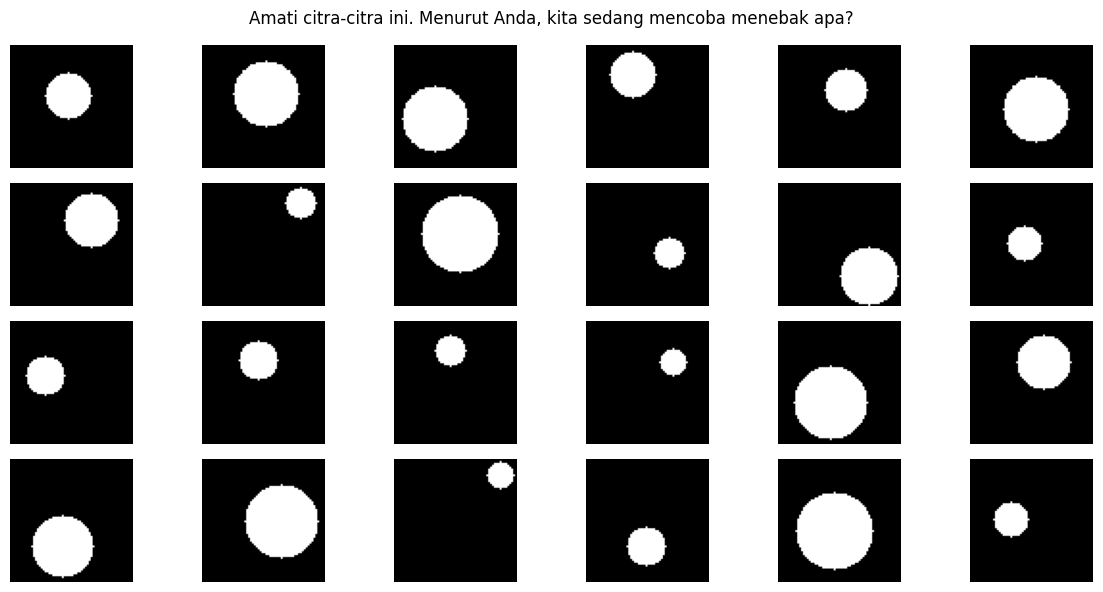

In [ ]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]

# Pisahkan komponen hasil
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label
cols = 6
rows = N_show // cols

plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?", fontsize=12)
plt.tight_layout()
plt.show()


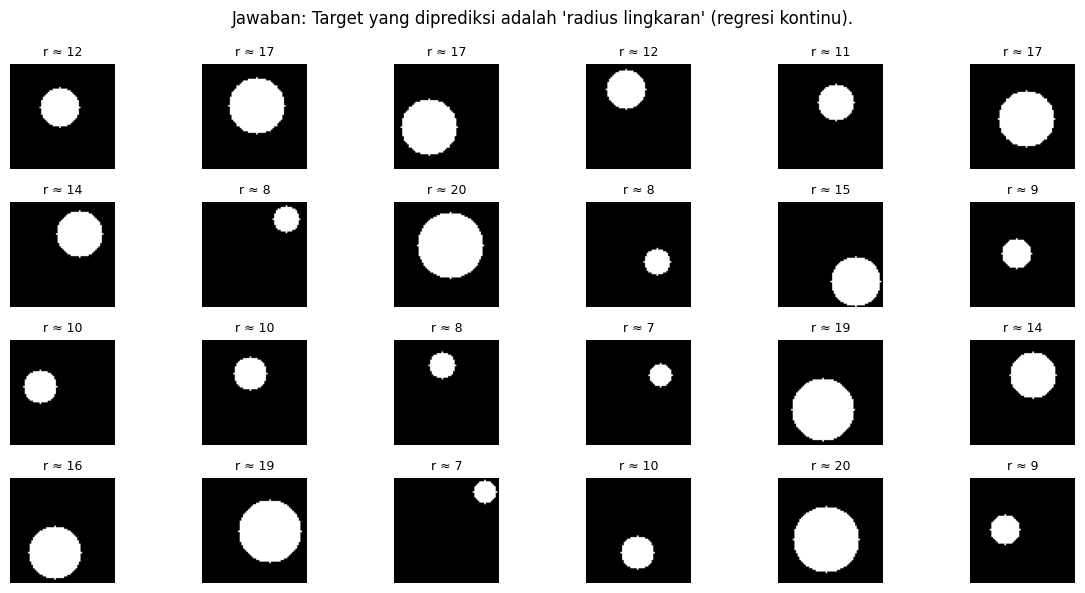

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))

for i in range(N_show):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}", fontsize=9)
    plt.axis('off')

plt.suptitle(
    "Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).",
    fontsize=12
)
plt.tight_layout()
plt.show()

In [ ]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Bagi dataset menjadi train dan test
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64, 64, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # output regresi
])

# Kompilasi model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training model
history = model.fit(
    Xtr, ytr,
    validation_data=(Xte, yte),
    epochs=12,
    batch_size=64,
    verbose=0
)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred) ** 2)))
r2 = r2_score(yte, y_pred)

print(f"MAE = {mae:.3f} | RMSE = {rmse:.3f} | R² = {r2:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
MAE = 0.956 | RMSE = 1.168 | R² = 0.935


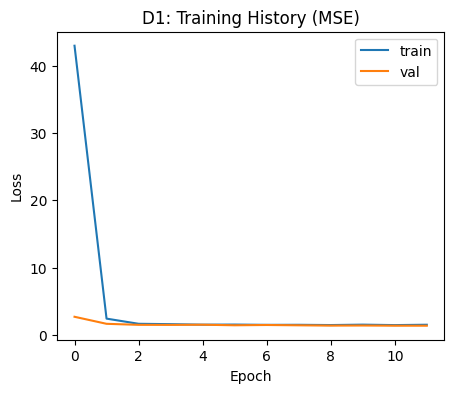

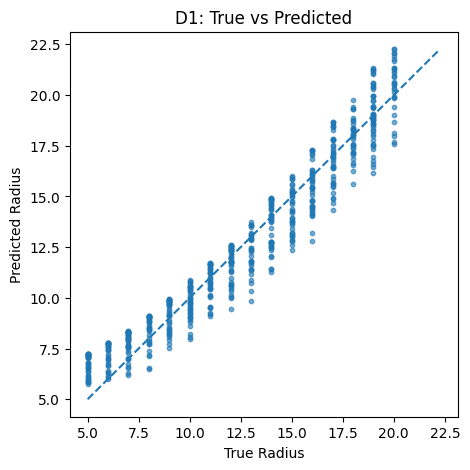

In [ ]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

5)	Tantangan Mini (Opsional untuk Mahasiswa)
•	Ubah rentang radius (mis. 8–28) dan lihat dampaknya ke MAE/RMSE/R².
•	Tambahkan noise (blur, noise Gaussian) ke citra → bagaimana performanya?
•	Jadikan tugas multi-output: prediksikan [r,cx,cy][r, c_x, c_y][r,cx,cy] sekaligus; metrik evaluasi apa yang cocok?


## Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)
Pernahkah Anda memperhatikan wajah seseorang dan mencoba menebak usianya? Mungkin dari garis senyum, bentuk rahang, atau tekstur kulit. Nah, komputer juga bisa melakukan hal yang sama — dengan belajar dari ribuan contoh wajah berlabel umur. Di praktikum ini, kita akan membuat sistem sederhana yang mampu memperkirakan umur seseorang dari fotonya menggunakan teknik regresi gambar.

Dataset yang digunakan bernama UTKFace, berisi ribuan foto wajah manusia dari berbagai usia, jenis kelamin, dan ras. Setiap foto memiliki nama file yang sudah menyimpan label umur. Contohnya:
11_0_0_20170110225327724.jpg.chip.jpg(5.92 kB)

Artinya, usia = 11 tahun, gender = laki-laki (0), ras = Asia (0). Namun kita hanya akan fokus pada nilai pertama (umur) sebagai target regresi.
Tujuan belajar:
•	Mengenal dataset wajah dan ekstraksi label dari nama file.

•	Menggunakan transfer learning pada model CNN.
•	Menerapkan regresi untuk masalah nyata (estimasi umur).


### Langkah 1 — Membuat Akun Kaggle dan Mengunduh kaggle.json
Agar dapat mengakses dataset publik Kaggle, mahasiswa perlu membuat akun terlebih dahulu.
Ikuti langkah berikut:
1.	Buka situs https://www.kaggle.com
2.	Daftar menggunakan email Google atau GitHub.
3.	Setelah login, klik profil di kanan atas → pilih “Account”.
4.	Gulir ke bawah ke bagian API → klik “Create New API Token”.
5.	File bernama kaggle.json akan otomatis terunduh ke komputer Anda.
File ini berisi API key pribadi agar Colab bisa mengakses dataset Kaggle Anda.
Simpan file kaggle.json dengan baik (jangan dibagikan ke orang lain).


Langkah 2 — Mengunggah kaggle.json ke Colab

In [14]:
# Jalankan ini di awal notebook
from google.colab import files
files.upload() # pilih file kaggle.json dari komputer Anda

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anisaaafn","key":"d1a712680e719815f7f0e7c7c578d424"}'}

Setelah diunggah, jalankan sel berikut untuk menyiapkan koneksi Kaggle:

In [15]:
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print(" .ı kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


Langkah 3 — Mengunduh Dataset UTKFace dari Kaggle


In [17]:
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

✅ Dataset UTKFace berhasil diekstrak.


Langkah 4 — Menampilkan Contoh Gambar Dataset

Sebelum	melatih	model,	mari	lihat	langsung	seperti	apa	data	wajahnya. Ini membantu mahasiswa memahami apa masalah yang sedang diselesaikan.


Total gambar ditemukan: 23708


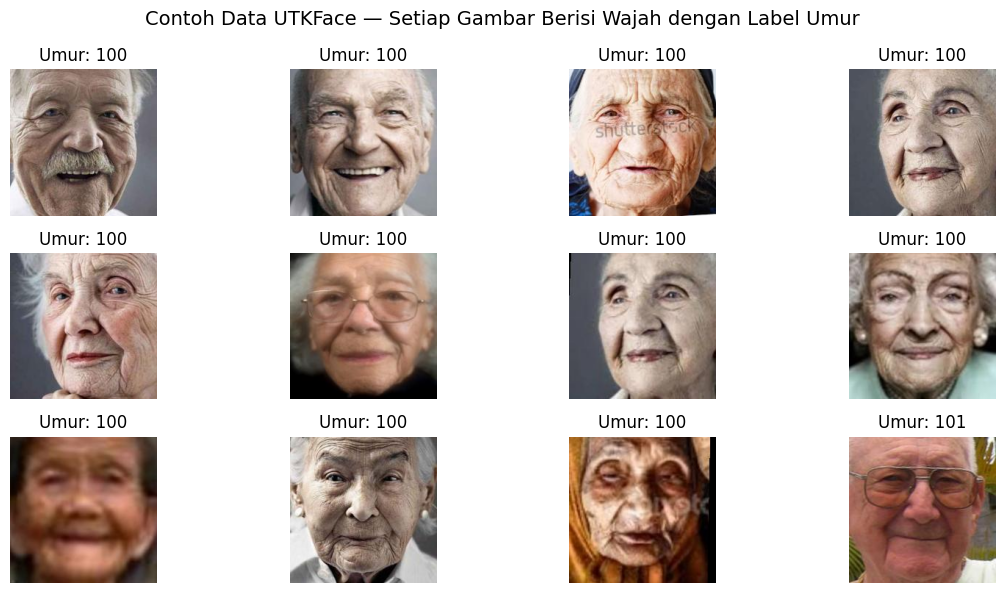

In [18]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]): # Ambil umur dari nama file
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

•◆. Hasil visualisasi: Mahasiswa akan melihat wajah-wajah dari berbagai usia (anak, remaja, dewasa, hingga lansia). Inilah masalah regresi yang akan kita selesaikan:
“Dari citra wajah, perkirakan umur seseorang dalam satuan tahun.”

Langkah 5 — Siapkan Dataset untuk Model
Berikut langkah singkat memuat gambar ke TensorFlow Dataset.

In [20]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# --- Fungsi bantu untuk mengambil label umur dari nama file ---
def parse_age_from_name(fp):
    # Nama file formatnya misal: "25_1_0_20170109150557335.jpg"
    return int(os.path.basename(fp).split('_')[0])

# --- Ambil daftar file dari dataset ---
files = tf.io.gfile.glob("/content/utk/UTKFace/*.jpg")  # pastikan path sesuai folder hasil unzip
print(f"Total gambar ditemukan: {len(files)}")

# --- Ambil label umur dari nama file ---
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)

# --- Pisahkan dataset menjadi train dan test ---
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

# --- Fungsi preprocessing gambar ---
IMG_SIZE = 160

def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

# --- Buat dataset TensorFlow ---
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_files, y_train))
    .map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_files, y_test))
    .map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

print("✅ Dataset siap dilatih.")

Total gambar ditemukan: 23708
✅ Dataset siap dilatih.


Langkah 6 — Membangun Model dengan Transfer Learning
Setelah memahami seperti apa data wajah di UTKFace, kita kini akan melangkah ke tahap inti:
membangun model deep learning untuk memprediksi umur dari foto.
Karena wajah memiliki pola kompleks — mata, kulit, ekspresi, pencahayaan — kita tidak akan melatih CNN dari nol.
Sebaliknya, kita akan menggunakan pendekatan transfer learning: memanfaatkan jaringan yang sudah belajar banyak tentang dunia visual (dari ImageNet), lalu menyesuaikannya sedikit untuk tugas regresi umur.
Model dasar yang kita gunakan adalah MobileNetV2 — ringan, cepat, dan cukup akurat untuk dataset wajah berukuran menengah seperti UTKFace.


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# --- Gunakan GPU jika tersedia ---
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# --- Buat arsitektur model ---
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

# Tahap awal: freeze backbone (feature extractor)
base_model.trainable = False

# --- Tambahkan head regresi ---
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)  # output tunggal: umur

model = tf.keras.Model(inputs, outputs)

# --- Kompilasi model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=['mae']
)

# --- Ringkasan model ---
model.summary()

Hardware: CPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Penjelasan singkat arsitektur:
•	MobileNetV2 sudah “terlatih melihat dunia”, kita hanya menyesuaikan layer akhir untuk memetakan wajah → umur.
•	GlobalAveragePooling2D mengubah fitur spasial menjadi vektor global.
•	Dropout membantu mencegah overfitting.
•	Output 1 neuron: prediksi umur dalam skala kontinu.

Langkah 7 — Melatih Model (Tahap 1 – Frozen)

Tahap pertama ini adalah pemanasan.
Kita hanya melatih bagian head regresi, sementara backbone-nya tetap beku. Tujuannya agar bagian atas bisa “belajar membaca” fitur wajah tanpa mengganggu pengetahuan umum MobileNetV2.

In [22]:
# --- Callback untuk pelatihan yang lebih stabil ---
cb = [
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=2,
        factor=0.5,
        min_lr=1e-5,
        monitor='val_loss'
    )
]

# --- Proses pelatihan model ---
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# --- Visualisasi perubahan loss dan MAE selama pelatihan ---
plt.figure(figsize=(8, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - loss: 339.9403 - mae: 13.7262 - val_loss: 149.4288 - val_mae: 9.2130 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - loss: 156.2832 - mae: 9.3654 - val_loss: 135.0116 - val_mae: 8.6540 - learning_rate: 0.0010
Epoch 3/10
164/297 ━━━━━━━━━━━━━━━━━━━━ 3:12 1s/step - loss: 144.0453 - mae: 8.9002

KeyboardInterrupt: 